# Regression for Price Prediction

[*********************100%***********************]  1 of 1 completed


AAPL Mean Squared Error: 27.6573


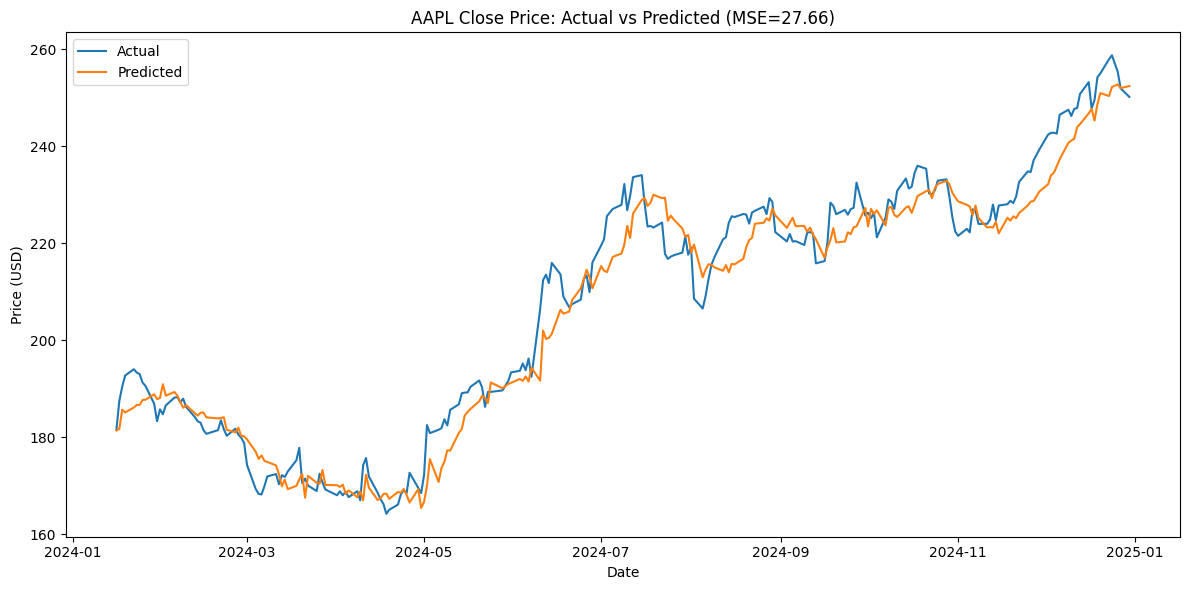

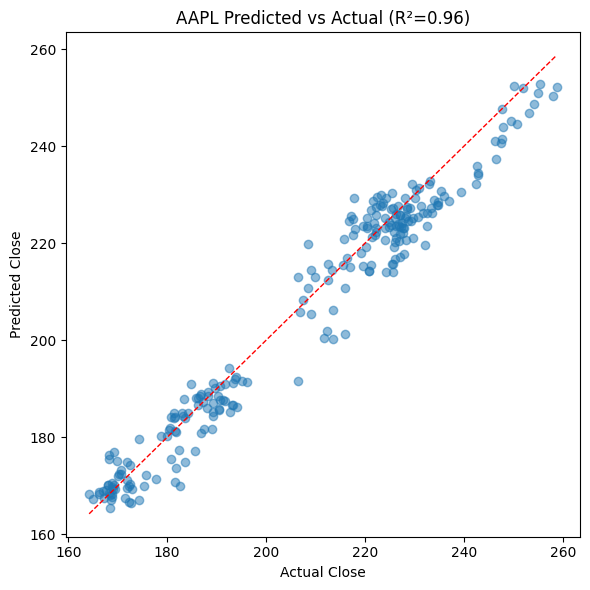

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1) Fetch data
stock = 'AAPL'
data = yf.download(stock, start='2020-01-01', end='2025-01-01')

# 2) Feature engineering
data['MA_10']      = data['Close'].rolling(10).mean()
data['MA_50']      = data['Close'].rolling(50).mean()
data['Volatility'] = data['Close'].rolling(10).std()
data['Returns']    = data['Close'].pct_change()
data.dropna(inplace=True)

# 3) Prepare X, y (next-day Close)
features = ['MA_10','MA_50','Volatility','Returns']
X = data[features]
y = data['Close'].shift(-1)
X = X.iloc[:-1]
y = y.iloc[:-1]

# 4) Train/test split (chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 5) Fit model & predict
model = LinearRegression()
model.fit(X_train, y_train)

raw_preds = model.predict(X_test)      # shape might be (n,1) or (n,)
raw_preds = np.ravel(raw_preds)        # force to shape (n,)

# 6) Flatten y_test as well (just in case it's a DataFrame)
y_test_arr = np.ravel(y_test)

# 7) Make two 1-D Series, with the correct dates & names
actual = pd.Series(y_test_arr,   index=y_test.index, name='Actual')
pred   = pd.Series(raw_preds,    index=y_test.index, name='Predicted')

# 8) Evaluate
mse = mean_squared_error(actual, pred)
print(f'{stock} Mean Squared Error: {mse:.4f}')

# 9) Concatenate into one DataFrame (chronological by index)
results = pd.concat([actual, pred], axis=1).sort_index()

# 10) Time-series overlay
plt.figure(figsize=(12,6))
plt.plot(results.index, results['Actual'],    label='Actual')
plt.plot(results.index, results['Predicted'], label='Predicted')
plt.title(f'{stock} Close Price: Actual vs Predicted (MSE={mse:.2f})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('price_prediction_timeseries.png')
plt.show()

# 11) Scatter: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(results['Actual'], results['Predicted'], alpha=0.5)
mn, mx = results['Actual'].min(), results['Actual'].max()
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
r2 = model.score(X_test, y_test)
plt.title(f'{stock} Predicted vs Actual (R²={r2:.2f})')
plt.xlabel('Actual Close')
plt.ylabel('Predicted Close')
plt.tight_layout()
plt.savefig('price_prediction_scatter.png')
plt.show()


# Classification for Trend Prediction

In [27]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Fetch stock data
stock = 'AAPL'
data = yf.download(stock, start='2020-01-01', end='2025-01-01')

# Feature engineering
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()
data['Volatility'] = data['Close'].rolling(window=10).std()
data['Returns'] = data['Close'].pct_change()

# Define target: 1 if price increases, 0 otherwise
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data.dropna(inplace=True)

# Define features and target
features = ['MA_10', 'MA_50', 'Volatility', 'Returns']
X = data[features]
y = data['Target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix:')
print(cm)

[*********************100%***********************]  1 of 1 completed


Accuracy: 0.5247933884297521
Confusion Matrix:
[[51 61]
 [54 76]]


# Reinforcement Learning for Trading

In [30]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Conversion of an array with ndim > 0 to a scalar is deprecated",
    category=DeprecationWarning,
)

import numpy as np
import pandas as pd
import yfinance as yf

# Fetch stock data
stock = 'AAPL'
data = yf.download(stock, start='2020-01-01', end='2025-01-01')
prices = data['Close'].values

# Q-learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
n_actions = 3
n_states = len(prices)

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def reward(state, action, next_state):
    if action == 0:      # Buy
        return prices[next_state] - prices[state]
    elif action == 1:    # Sell
        return prices[state] - prices[next_state]
    else:                # Hold
        return 0

# Train Q-learning agent
for episode in range(100):
    state = 0
    while state < n_states - 1:
        if np.random.rand() < epsilon:
            action = np.random.randint(n_actions)
        else:
            action = np.argmax(Q[state])
        next_state = state + 1
        r = reward(state, action, next_state)
        Q[state, action] += alpha * (
            r + gamma * np.max(Q[next_state]) - Q[state, action]
        )
        state = next_state

# Simulate trading
portfolio, cash = 0, 10000
for state in range(n_states - 1):
    action = np.argmax(Q[state])
    if action == 0 and cash >= prices[state]:
        portfolio += 1
        cash -= prices[state]
    elif action == 1 and portfolio > 0:
        portfolio -= 1
        cash += prices[state]

final_value = cash + portfolio * prices[-1]
print(f'Final Portfolio Value: {final_value}')


[*********************100%***********************]  1 of 1 completed


Final Portfolio Value: [20942.0658226]


# Deep Learning for Trading

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


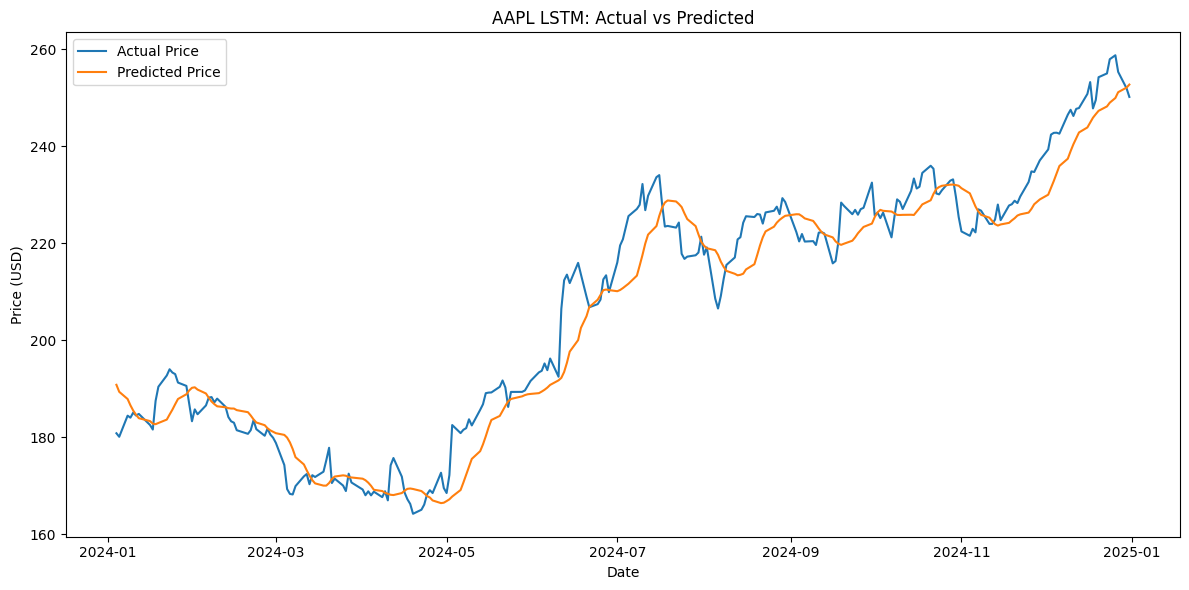

In [17]:
import os
# 1) Quiet TF’s C++ and Python logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'              # ignores INFO/WARNING from C++ backend
import tensorflow as tf
tf.get_logger().setLevel('ERROR')                    # ignores tf.function retracing warnings

import warnings
# 2) Suppress that Keras UserWarning
warnings.filterwarnings(
    "ignore",
    message="Do not pass an `input_shape`/`input_dim` argument to a layer"
)

import yfinance as yf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 3) Fetch stock data (no progress bar)
stock = 'AAPL'
data = yf.download(stock, start='2020-01-01', end='2025-01-01', progress=False)
prices = data['Close'].values

# 4) Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(prices.reshape(-1,1))

# 5) Build sequence dataset
sequence_length = 10
X, y = [], []
for i in range(len(scaled) - sequence_length):
    X.append(scaled[i:i+sequence_length])
    y.append(scaled[i+sequence_length])
X = np.array(X)
y = np.array(y)

# 6) Train/test split (chronological)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 7) Build & train LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length,1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# 8) Predict and invert scaling
preds = model.predict(X_test)            # shape (n_test, 1)
preds = scaler.inverse_transform(preds)  # still (n_test, 1)
preds = preds.ravel()                    # now (n_test,)

# 9) Build the date index and actual-price slice
test_dates    = data.index[sequence_length + split :]
actual_prices = prices[sequence_length + split :]

# sanity-check lengths
assert len(preds) == len(actual_prices) == len(test_dates)

# 10) Plot time series
plt.figure(figsize=(12,6))
plt.plot(test_dates, actual_prices, label='Actual Price')
plt.plot(test_dates, preds,        label='Predicted Price')
plt.title(f'{stock} LSTM: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('lstm_price_timeseries.png')
plt.show()
